##Importing Libraries and initializing variables

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random 
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 17

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [ ]:
N = 16
Re = 1
f_a = 1/4

#Exercise 1: Monte-Carlo simulation of a single chain in a spherical micelle

##1.a: Monte Carlo simulation of the copolymer

###1.a.1: Defining the $ω_A$ and $ω_B$ functions
In this section we read the data from the "omega.dat" file and make functions to determine the value of the extenal fields in position r, using interpolation.

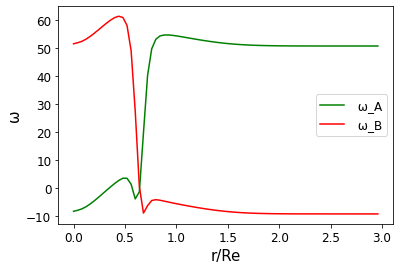

In [ ]:
data = pd.read_table("omega.dat",delimiter=' ')

distance = np.array(list(data.iloc[:,0]))
WA = np.array(list(data.iloc[:,1]))
WB = np.array(list(data.iloc[:,2]))
plt.plot(distance,WA , label =' \u03C9_A' , c='g')
plt.plot(distance,WB , label =' \u03C9_B' , c = 'r')
plt.ylabel('\u03C9')
plt.xlabel('r/Re')
plt.legend()


def W_A(r):
  r_Re = r / Re
  return np.interp(r_Re , distance , WA)
  

def W_B(r ):
  r_Re = r / Re
  return np.interp(r_Re , distance , WB)

###1.a.2: Initialazing the beads positions
Function "copolymer()" makes a 16 beads copolymer with initial configuration (0.1 * i , 0.1 * i , 0.1 * i).

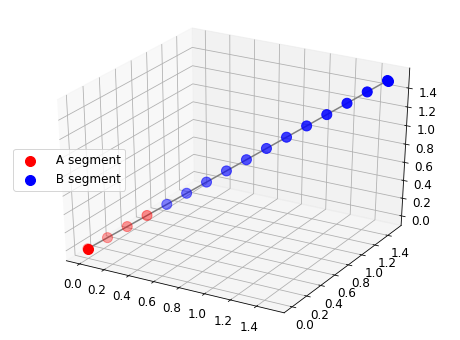

In [ ]:
def copolymer():                        ### This function makes an initial polymer with length N on the X_axis and return an N * 3 matrix of position of each bead.
  initial = np.array([[0.1*i ,0.1*i ,0.1*i]for i in range(N)])
  return initial


example_polymer = copolymer()
fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection='3d')
colors = ['r' for i in range(int(f_a * N))]+ ['b' for i in range(int((1-f_a) * N))]
ax.plot3D(example_polymer.T[0], example_polymer.T[1], example_polymer.T[2], 'gray')
ax.scatter3D(example_polymer.T[0], example_polymer.T[1], example_polymer.T[2],  c = colors, s = 100)
ax.scatter3D(example_polymer.T[0][0], example_polymer.T[1][0], example_polymer.T[2][0],  c = 'r', s = 100 , label = ' A segment')
ax.scatter3D(example_polymer.T[0][-1], example_polymer.T[1][-1], example_polymer.T[2][-1],  c = 'b', s = 100 , label = ' B segment')
plt.legend(loc='center left')

###1.a.3: Defining the Hamiltonian of the system
The "Hamiltonian(polymer, w_a, w_b , k , r_umbrella )" function includes 3 parts:

1.   The Hamiltonian of the bead_spring model between neighboring beads.
2.   The Hamiltonian of the external fields acting on the A and B segments.(if applicable)
3.   The umbrella potetial.(if applicable)








In [ ]:
def Hamiltonian(polymer, w_a, w_b , k , r_umbrella ):                            
  #####Bead_spring
  distance = np.array([np.sqrt(np.sum((polymer[i]- polymer[i-1])**2)) for i in range(1,N) ])
  neighbors_interaction =(3 * (N-1) / (2* Re**2) )* np.sum(distance**2)             
  N_A = int ( N * f_a)
  ####External fields
  if w_a :
    A_segment = polymer[:N_A]
    A_field = 1 / N * np.sum(W_A(np.sqrt(np.sum(A_segment**2,axis = 1))))
  else : 
    A_field = 0

  if w_b :
    B_segment = polymer[N_A:]
    B_field = 1 / N * np.sum(W_B(np.sqrt(np.sum(B_segment**2,axis = 1))))
  else:
    B_field = 0
  ########Umbrella sampling potential
  rj = np.sqrt(np.sum(((polymer[3] + polymer[4])/2)**2))           
  umbrella = (k*(rj- r_umbrella)**2)/(2*Re**2)
  ########
  
  normalized_H = neighbors_interaction + A_field + B_field + umbrella                      # normalized_H = H / KT

  return normalized_H

###1.a.4: Defining the MCMC steps and simulations 


*   "Metropolis_step" function do the displacement of a random bead and decide whether to accept it or not. 
*   "Monte_Carlo" function does a n_step times *for* over the Metropolis function and returns a list that contains the position of all beads in all steps.


*   "MC" functions does a n_trial times *for* over the "Monte_Carlo" function and returns a list of all the beads positions, in all the steps of all the trials(the output shape is a numpy array of [number of trials , number of step, number of beads, 3D position]






In [ ]:
def Metropolis_step(Polymer ,w_a , w_b , k ,r_umbrella):                                           ### This function change the position of a random bead and check the detailed balanced condition to accept it or not and if it accept it, the new matrix of positions will get returned.
  delta_max = Re / np.sqrt(N-1)
  delta = np.random.uniform(low = -delta_max , high = delta_max , size = 3 )
  random_segment = random.randint(0,N-1) 
  Polymer_test = Polymer.copy()
  Polymer_test[random_segment] += delta

  H_0 = Hamiltonian(Polymer,w_a , w_b, k ,r_umbrella)
  H_t = Hamiltonian(Polymer_test,w_a , w_b,k ,r_umbrella)
  while (True) :  
    random_number = np.random.uniform(low = 0 , high = 1)
    acc_probability = min([1 , np.exp(-(H_t - H_0))])
    if random_number <= acc_probability:
      return Polymer_test
    else: 
      delta = np.random.uniform(low = -delta_max , high = delta_max , size = 3 )
      random_segment = random.randint(0,N-1)
      Polymer_test = Polymer.copy()
      Polymer_test[random_segment] += delta
      H_0 = Hamiltonian(Polymer,w_a,w_b,k , r_umbrella)
      H_t = Hamiltonian(Polymer_test,w_a,w_b,k ,r_umbrella) 
        


def Monte_Carlo (num_steps , eq_t  ,w_a , w_b , k , r_umbrella,init_rj):             ### This function does a Monte Carlo simulation of a N_bead-spring system, and goes for "num_steps" number of steps and records the end to end distance at each accepted step and return them all in a list.
  initial_polymer = copolymer()  
  positions_list = []
  new_polymer = initial_polymer.copy()
  for i in range(num_steps):
    new_polymer = Metropolis_step(new_polymer , w_a , w_b , k ,r_umbrella )
    if i > eq_t:
      positions_list.append(new_polymer)    
  return np.array(positions_list)



def MC (trial_num = 50 , steps_num = 50000,equilibrium_time = 0 , w_a = True , w_b = True , k =0 , r_umbrella=0,init_rj = 0.35):
  trial_list = []
  for j in range(trial_num):
      # print(j)
      trial = Monte_Carlo(steps_num , equilibrium_time ,w_a , w_b,k , r_umbrella,init_rj  )
      trial_list.append(trial)

  return np.array(trial_list) 


##1.b: Checking the validation of the simulation
In this section we check the validity of our simulation by finding:

    *   the mean and variance of the end to end distance in absence of the external fields.
    *   Mean squared distance(MSD) for the center of mass and the junction point in absence of the external fields.
    *   density profile for the A and B segments, the center of mass and the junction point in presence of the external fields.




###1.b.1: Validatation in absence of the external fields($ω_A$ = $ω_B$ = 0)


####1.b.1-1: Finding the equilibrium time for the system
We start the simulation from an arbitrary configuration. For calculating the parameters of the system, we need to find a time at which the system reaches equilibrium and fluctuates around that.

In [ ]:
n_trial = 10
n_step = 40000
Trials = MC (trial_num=n_trial,steps_num = n_step ,w_a = False, w_b = False) 

In [ ]:
end_to_end = np.mean(Trials[:,:,0,:] - Trials[:,:,-1,:] , axis = 0)
X_list = end_to_end[:,0]
Y_list = end_to_end[:,1]
Z_list = end_to_end[:,2]
R2_mean = np.mean(np.sum((Trials[:,:,0,:] - Trials[:,:,-1,:])**2 , axis = 2),axis = 0)

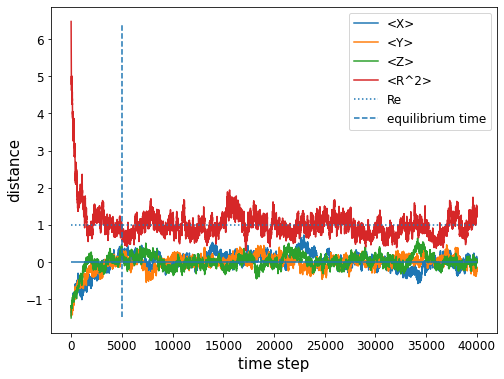

In [ ]:
eq = 5000
fig, ax = plt.subplots(1,1 , figsize=(8,6))
ymin = 1.1 * min([min(X_list) , min(Y_list) ,min(Z_list) ])
ymax = 1.1 * max(R2_mean)

ax.plot(X_list,label='<X>')
ax.plot(Y_list , label = '<Y>')
ax.plot(Z_list , label = '<Z>')
ax.plot(R2_mean , label = '<R^2>')

ax.hlines(0,0,n_step)
ax.hlines(1,0,n_step , linestyle = 'dotted',label = 'Re')
ax.vlines(eq, 0.9 * ymin , 0.9 * ymax , linestyle = 'dashed', label = 'equilibrium time')
# ax.set_title('end to end distance\'s time evolution')
ax.set_ylabel('distance')
ax.set_xlabel('time step')
ax.legend(loc='upper right')

based on the above plot, we can consider the t = 5000 steps as the equilibrium time.

####1.b.1-2: Finding $<R>$ and $<R^2>$ 

In [ ]:
end_to_end = Trials[:,eq:,0,:] - Trials[:,eq:,-1,:]
X_list = end_to_end[:,:,0].flatten()
Y_list = end_to_end[:,:,1].flatten()
Z_list = end_to_end[:,:,2].flatten()
CM_List = np.mean(Trials, axis=2 )
J_List = (Trials[:,:,4,:] + Trials[:,:,3,:])/2

def Gussian(x , m , v):                                                         ### This function is a Gussian distribution with mean and variance equal to the mean and variance of the R of the above run. 
  return (1/np.sqrt(2 * np.pi * v) )* np.exp(-((x - m)**2)/(2*v))


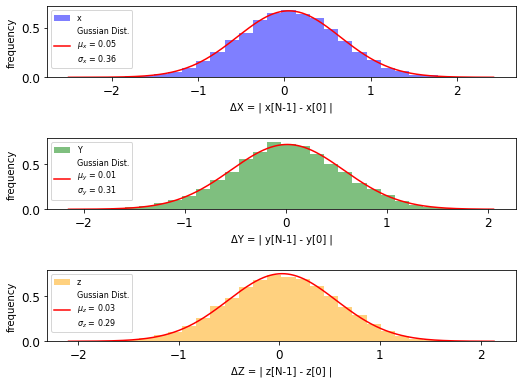

In [ ]:
fig, ax = plt.subplots(3,1 , figsize=(8,6))
fig.tight_layout(pad=3.0)

####X_List
X = np.arange(min(X_list) , max(X_list) , 0.01)
Y = Gussian(X, np.mean(X_list) , np.var(X_list))

ax[0].hist(X_list,bins = 30 , density= True, alpha = 0.5 , label='x' , color = 'blue')
ax[0].plot(X,Y , c = 'r', label = 'Gussian Dist.\n$\u03BC_x$ = ' + str(round(np.mean(X_list),2))+'\n$\u03C3_x$ = '+ str(round(np.var(X_list),2)))

ax[0].set_xlabel('\u0394X = | x[N-1] - x[0] |' , fontsize = 10)
ax[0].set_ylabel('frequency' , fontsize = 10)
ax[0].legend( loc='upper left',fontsize = 8)


####Y_List
X = np.arange(min(Y_list) , max(Y_list) , 0.01)
Y = Gussian(X, np.mean(Y_list) , np.var(Y_list))

ax[1].hist(Y_list,bins = 30 , density= True, alpha = 0.5 , label='Y' , color = 'g')
ax[1].plot(X,Y , c = 'r', label = 'Gussian Dist.\n$\u03BC_y$ = ' + str(round(np.mean(Y_list),2))+'\n$\u03C3_y$ = '+ str(round(np.var(Y_list),2)))

ax[1].set_xlabel('\u0394Y = | y[N-1] - y[0] |' , fontsize = 10)
ax[1].set_ylabel('frequency' , fontsize = 10)
ax[1].legend( loc='upper left',fontsize = 8)

####Z_list
X = np.arange(min(Z_list) , max(Z_list) , 0.01)
Y = Gussian(X, np.mean(Z_list) , np.var(Z_list))

ax[2].hist(Z_list,bins = 30 , density= True, alpha = 0.5 , label='z' , color = 'orange')
ax[2].plot(X,Y , c = 'r', label = 'Gussian Dist.\n$\u03BC_z$ = ' + str(round(np.mean(Z_list),2))+'\n$\u03C3_z$ = '+ str(round(np.var(Z_list),2)))

ax[2].set_xlabel('\u0394Z = | z[N-1] - z[0] |' , fontsize = 10)
ax[2].set_ylabel('frequency' , fontsize = 10)
ax[2].legend( loc='upper left',fontsize = 8)


As we can see above, all components of the end to end distance are Gaussian distributed with mean around zero and variance around 0.33.

###1.b.2: Calculation of the MSD for the center of mass and junction point

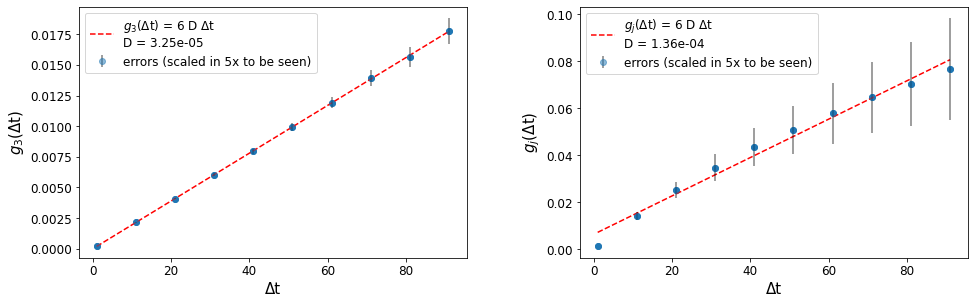

In [ ]:
delta_t = np.arange(1,100,10)
g3 = []
g3err = []
g_j = []
gjerr = []
for dt in delta_t:
  CM_dt = CM_List[:,: :int(dt),:]
  g3.append(np.mean(np.sum((CM_dt[:,1:,:] - CM_dt[:,:-1,:])**2,axis=2)))
  g3err.append(np.var(np.sum((CM_dt[:,1:,:] - CM_dt[:,:-1,:])**2,axis=2)))
  J_dt = J_List[:,: :int(dt),:]
  g_j.append(np.mean(np.sum((J_dt[:,1:,:] - J_dt[:,:-1,:])**2,axis=2)))
  gjerr.append(np.var(np.sum((J_dt[:,1:,:] - J_dt[:,:-1,:])**2,axis=2)))




fig, ax = plt.subplots(1,2 , figsize=(15,6))
fig.tight_layout(pad=6.5)

####MSD _ CM
D , d = np.polyfit(6 * delta_t , g3,1)
ax[0].scatter(delta_t , g3)
ax[0].plot(delta_t , delta_t * 6 * D + d ,'--' ,c = 'r',label = '$g_3$(\u0394t) = 6 D \u0394t\nD = '+ "{:.2e}".format(D))
ax[0].errorbar(delta_t, g3, yerr = np.array(g3err)*5,
             fmt='o', ecolor = 'black', alpha = 0.5 , label = 'errors (scaled in 5x to be seen)')
ax[0].set_xlabel('\u0394t')
ax[0].set_ylabel('$g_3$(\u0394t)')
# ax[0].set_title('MSD of center of mass')
ax[0].legend(loc='upper left')

####MSD _ Junction
D , d = np.polyfit(6 * delta_t , g_j,1)
ax[1].scatter(delta_t , g_j)
ax[1].plot(delta_t , delta_t * 6 * D  + d, '--',c = 'r',label = '$g_j$(\u0394t) = 6 D \u0394t\nD = '+ "{:.2e}".format(D))
ax[1].errorbar(delta_t, g_j, yerr = np.array(gjerr)*5,
             fmt='o', ecolor = 'black',alpha = 0.5, label = 'errors (scaled in 5x to be seen)')
ax[1].set_xlabel('\u0394t')
ax[1].set_ylabel('$g_j$(\u0394t)')
# ax[1].set_title('MSD of the junction point')
ax[1].legend(loc= 'upper left')

###1.b.3: Calculation of the radial density profiles in the presence of external fields($ω_A≠0$ and $ω_B≠0$)

In [ ]:
n_trial_fields_on = 10
n_step_fields_on = 20000
Trials_fields_on = MC (trial_num = n_trial_fields_on,steps_num = n_step_fields_on, equilibrium_time = 1 ,w_a = True, w_b = True) 

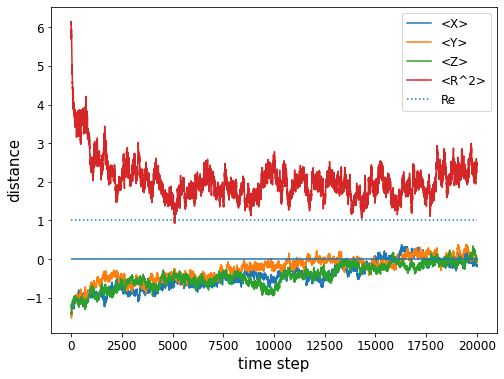

In [ ]:
end_to_end_on = np.mean(Trials_fields_on[:,:,0,:] - Trials_fields_on[:,:,-1,:] , axis = 0)
X_list_on = end_to_end_on[:,0]
Y_list_on = end_to_end_on[:,1]
Z_list_on = end_to_end_on[:,2]
R2_mean_on = np.mean(np.sum((Trials_fields_on[:,:,0,:] - Trials_fields_on[:,:,-1,:])**2 , axis = 2),axis = 0)

fig, ax = plt.subplots(1,1 , figsize=(8,6))
ymin = 1.1 * min([min(X_list_on) , min(Y_list_on) ,min(Z_list_on) ])
ymax = 1.1 * max(R2_mean_on)

ax.plot(X_list_on,label='<X>')
ax.plot(Y_list_on , label = '<Y>')
ax.plot(Z_list_on , label = '<Z>')
ax.plot(R2_mean_on , label = '<R^2>')

ax.hlines(0,0,n_step_fields_on)
ax.hlines(1,0,n_step_fields_on , linestyle = 'dotted',label = 'Re')
# ax.set_title('end to end distance\'s time evolution (fields ON)')
ax.set_ylabel('distance')
ax.set_xlabel('time step')
ax.legend(loc='upper right')

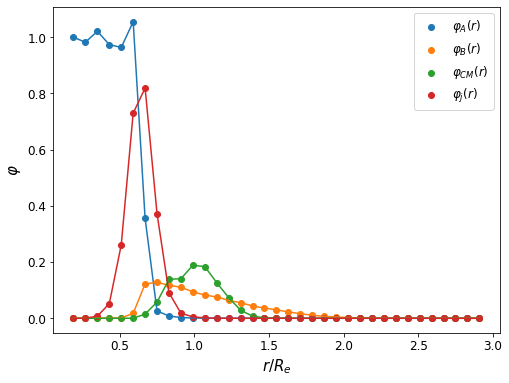

In [ ]:
r_distance = np.sqrt(np.sum(Trials_fields_on**2,axis=3))
com_on = np.mean(np.sqrt(np.sum(Trials_fields_on[:,10000:,:,:]**2,axis=3)),axis = 2).flatten()
j_pos_on_t = np.sqrt(np.sum(((Trials_fields_on[:,10000:,3,:] + Trials_fields_on[:,10000:,4,:] )/2 )**2 , axis = 2)).flatten()


A_segment_on = r_distance[:,10000:,:4].flatten()
B_segment_on = r_distance[:,10000:,4:].flatten()


d_r = 0.08
r_R = np.arange(0.15 ,3,d_r)
corrected_r_R = ((r_R[1:] +r_R[:-1])/2)
volume = 4* np.pi * corrected_r_R **2 * d_r


com_hist = np.histogram(com_on , r_R)[0] / (volume*len(com_on))

J_on_hist = np.histogram(j_pos_on_t , r_R)[0] / (volume*len(j_pos_on_t))

A_density_on = np.histogram(A_segment_on , r_R)[0] / (volume*len(A_segment_on))

B_density_on = np.histogram(B_segment_on , r_R)[0] / (volume*len(B_segment_on))


fig, ax = plt.subplots(1,1 , figsize=(8,6))
normalization = A_density_on[0]+B_density_on[0]

ax.scatter(corrected_r_R,A_density_on/normalization , label = '$\u03C6_A(r)$')
ax.scatter(corrected_r_R,B_density_on/normalization , label = '$\u03C6_B(r)$')
ax.scatter(corrected_r_R,com_hist , label = '$\u03C6_{CM}(r)$')
ax.scatter(corrected_r_R,J_on_hist , label = '$\u03C6_j(r)$')

ax.plot(corrected_r_R,A_density_on/normalization)
ax.plot(corrected_r_R,B_density_on/normalization)
ax.plot(corrected_r_R,com_hist)
ax.plot(corrected_r_R,J_on_hist )


ax.set_xlabel('$r/R_e$')
ax.set_ylabel('$\u03C6$')
ax.legend()

##1.c: Umbrella sampling and calculating $\left<(r_j-r)^2\right>_{\pi_k}$
We run the above Monte Carlo simulation for a range of r values with k = 10000 and in each simulation we find the value of the $<(r-r_j)^2>$.

In [40]:
mean_r_rj_2 = []
std_r_rj_2 = []
r_0_list = np.arange(0.001,3,0.1)
for r_0 in r_0_list:
  print(r_0)
  n_trial = 10
  n_step = 5000
  equilibrium_st = 1000
  k_value = 10000
  Trials = MC (trial_num=n_trial,steps_num = n_step,equilibrium_time = 1 ,w_a = True, w_b = True, k = k_value,r_umbrella = r_0)
  mean_r_rj_2.append(np.sqrt(np.mean((np.sqrt(np.sum((((Trials[:,equilibrium_st:,3,:] + Trials[:,equilibrium_st:,4,:] )/2 )**2),axis=2)).flatten() - r_0)**2)))
  std_r_rj_2.append(np.sqrt(np.var((np.sqrt(np.sum((((Trials[:,equilibrium_st:,3,:] + Trials[:,equilibrium_st:,4,:] )/2 )**2),axis=2)).flatten() - r_0)**2)))

0.001


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


0.101
0.201
0.30100000000000005
0.401
0.501
0.6010000000000001
0.7010000000000001
0.801
0.901
1.001
1.101
1.201
1.301
1.401
1.501
1.601
1.701
1.801
1.901
2.001
2.101
2.201
2.301
2.4010000000000002
2.501
2.601
2.701
2.801
2.9010000000000002


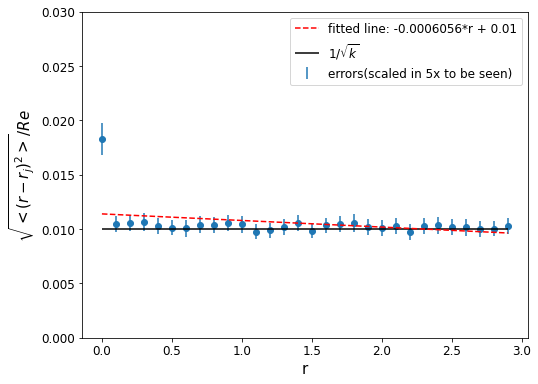

In [42]:
fig, ax = plt.subplots(figsize = (8,6))

ax.scatter(r_0_list , mean_r_rj_2 )
ax.errorbar(r_0_list , mean_r_rj_2 , yerr = 5*np.array(std_r_rj_2),linestyle='',label = 'errors(scaled in 5x to be seen)')
slope, intercept = np.polyfit(r_0_list, mean_r_rj_2, 1)
ax.plot(r_0_list, slope*r_0_list+intercept,'--',c = 'r' , label= 'fitted line: {0}*r + {1}'.format(round(slope,7),round(intercept,2)))
ax.set_ylim(0.000,0.03)
# plt.xlim(,10)
ax.set_ylabel('$\sqrt{<(r-r_j)^2>}/Re$')
ax.set_xlabel('r')
ax.hlines(1/np.sqrt(10000) , np.min(r_0_list), np.max(r_0_list) , label = '$1/\sqrt{k}$')
ax.legend()

##1.d: Umbrella sampling and calculating $dF/dr$
We run the Monte Carlo simulation for a range of r values with k = 10000 and in each simulation we find the value of $r_j$. Then we plot a histogram based on this data. 
$Δr$ is chosen to be 0.01, then the neighboring histograms have overlaps. 

In [ ]:
junction_point = []
k_value = 10000
delta_r = 0.01
r_0_list = np.arange(0.001,3,delta_r)
for r_0 in r_0_list:
  print(r_0,'r_0')
  n_trial = 1
  n_step = 10000
  equilibrium_st = 1000
  k_value = 10000
  print(r_0)
  Trials = MC (trial_num=n_trial,steps_num = n_step,equilibrium_time = 1 ,w_a = True, w_b = True, k = k_value,r_umbrella = r_0)
  junction_point.append(np.sqrt(np.sum(((Trials[:,500:,3,:] + Trials[:,500:,4,:] )/2)**2, axis = 2).flatten()))


Text(0, 0.5, 'frequency')

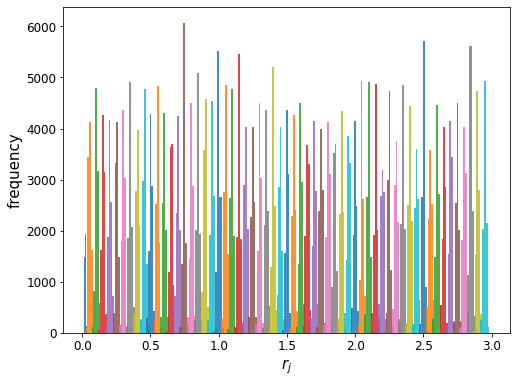

In [ ]:
fig, ax = plt.subplots(figsize = (8,6))
for i in range(len(junction_point)):
  if i%5 ==0 :
    ax.hist(np.array(junction_point[i]),bins = 5, label = i,alpha = 0.85)

ax.set_xlabel('$r_j$')
ax.set_ylabel('frequency')


###Caculating the $dF/dr$ integral to find the free energy profile

In [ ]:
mean_r_j1 = [np.mean(junction_point[i]) - r_0_list[i] for i in range(len(junction_point))]
norm_r_j = [np.mean(mean_r_j1[i-3:i+3]) for i in range(3,len(mean_r_j1)-3)]
norm_r_list = r_0_list[3:-3]
F_r_1 = k_value*(- np.array([np.sum(np.array(norm_r_j)[:i]) * delta_r for i in range(len(norm_r_j))]) )
F_r_1 = F_r_1 - np.min(F_r_1)

ind_F_min = np.argmin(F_r_1)
r_min = norm_r_list[ind_F_min]
ind_F_max = np.argmax(F_r_1[np.argmin(F_r_1):200])+np.argmin(F_r_1)
r_max = norm_r_list[ind_F_max]

print("r_min = " , r_min)
print("r_max = " , r_max)

r_min =  0.6709999999999999
r_max =  1.5309999999999997


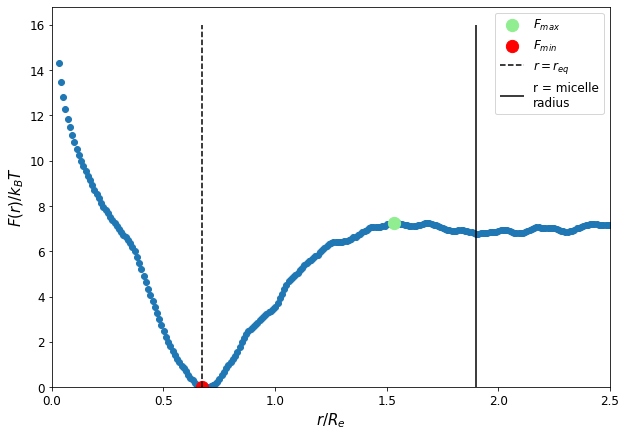

In [ ]:
fig, ax = plt.subplots(figsize = (10,7))

ax.scatter(norm_r_list,F_r_1)
ax.scatter(r_max,F_r_1[ind_F_max] , label = '$F_{max}$',s = 150,color = 'lightgreen')
ax.scatter(r_min,F_r_1[ind_F_min] , label = '$F_{min}$',s = 150 , color = 'r')
ax.vlines(r_min, 0,16,linestyles = '--' ,label = '$r = r_{eq}$')
ax.vlines(1.9, 0,16,linestyles = '-' ,label = 'r = micelle\nradius')
ax.set_xlim(0,2.5)
ax.set_ylim(0)
ax.set_ylabel('$F(r)/k_BT$')
ax.set_xlabel('$r/R_e$')
ax.legend()

#Exercise 2: Escape rate via forward-flux sampling

##2.b: Forward_flux Sampling
This function makes an initial polymer with its junction point at the given "init_rj" position. Then it runs Monte Caro steps until the junction point reaches the next interface or the 0th interface. Then it gives the final position of the junction point as the output.

In [ ]:
def FFS(w_a = True, w_b = True,init_rj=0.35 , upper_limit=2, lower_limit = 0.5):
  l = init_rj * 2 / 7
  initial_polymer = np.array([[l*i ,0 ,0]for i in range(N)])
  new_polymer = initial_polymer.copy()
  j_position  = np.sqrt(np.sum(((new_polymer[3] + new_polymer[4])/2)**2)) 
  st = 0
  while (j_position >= lower_limit and j_position <= upper_limit):
    st += 1
    new_polymer = Metropolis_step(new_polymer , w_a , w_b , k =0 , r_umbrella=0 )
    j_position  = np.sqrt(np.sum(((new_polymer[3] + new_polymer[4])/2)**2)) 
    if st >= 2000:
        l = init_rj * 2 / 7
        initial_polymer = np.array([[l*i ,0 ,0]for i in range(N)])
        new_polymer = initial_polymer.copy()
        j_position  = np.sqrt(np.sum(((new_polymer[3] + new_polymer[4])/2)**2)) 
        st = 0
  return j_position


Now we do a 1000 times "for" over the "FFS" function in each interface. It means that in each interface, we run 1000 simulation with initial position of the junction point at that interface and run the FFS function till we find the final position of the junction point for each simulation and we count the number of final positions that passes the next interface as the successfull simulation and find P(i|i+1) = # successfull simulations / # total simulations.

In [ ]:
r_min =  0.65
r_max =  1.7


n_trial = 1000
interface_list = np.arange(r_min,r_max,0.015)
P =np.zeros(len(interface_list)-1)

for i in range(len(interface_list)-1):
    print(interface_list[i],'interface')
    success = 0
    for trial in range(n_trial):
        final_j_pos = FFS(w_a = True, w_b = True,init_rj = interface_list[i] , upper_limit=interface_list[i+1], lower_limit = interface_list[0])
        if final_j_pos > interface_list[i+1]:
            success += 1
        elif final_j_pos < interface_list[0]:
            success += 0
    P[i] = success/n_trial
    print(P[i])



Text(0.5, 0, '$r/R_e$')

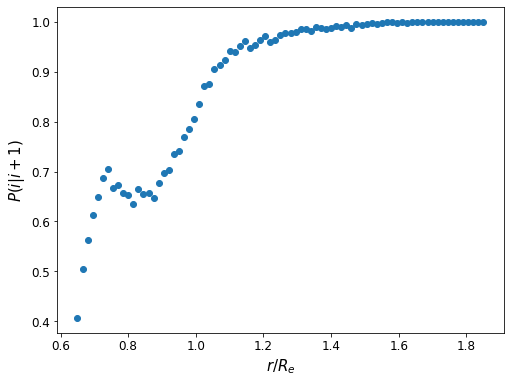

In [ ]:
fig, ax = plt.subplots(figsize = (8,6))

ax.scatter(interface_list[:-1],P)
ax.set_ylabel("$P(i|i+1)$")
ax.set_xlabel("$r/R_e$")

The final escape rate is the product of all the conditional probabilities.

In [ ]:
Eta = np.prod(P)
print("Calculated escape rate is " , Eta)

Calculated escape rate is  1.0438804685471137e-05


For finding the statistical error of the simulation, we run the whole above mentioned forward flux sampling 10 times with different random number seeds(actually I do not set the seeds at each simulation and it just uses the current time of the system, so they are independent).


In [ ]:
r_min =  0.65
r_max =  1.7


n_trial = 1000
interface_list = np.arange(r_min,r_max,0.02)
P =np.zeros((len(interface_list)-1,10))
for seed in range(10):
  print(seed,"seed")
  for i in range(len(interface_list)-1):
      if i%10 == 0 :
        print(interface_list[i],'interface')
      success = 0
      for trial in range(n_trial):
          final_j_pos = FFS(w_a = True, w_b = True,init_rj = interface_list[i] , upper_limit=interface_list[i+1], lower_limit = interface_list[0])
          if final_j_pos > interface_list[i+1]:
              success += 1
          elif final_j_pos < interface_list[0]:
              success += 0

      P[i][seed] = success/n_trial
      print(P[i][seed])
  print(np.prod(P.T[seed]))


In [ ]:
P_mean = [np.mean(P[i]) for i in range(len(interface_list)-1)]
P_std = [np.std(P[i]) for i in range(len(interface_list)-1)]


fig, ax = plt.subplots(figsize = (8,6))

ax.scatter(interface_list[:-1],P_mean)
ax.errorbar(interface_list[:-1], P_mean, yerr=5*np.array(P_std))
ax.set_ylabel("$P(i|i+1)$")
ax.set_xlabel("$r/R_e$")
ax.set_xlim(0.65 ,1.7 )

The final escape rate is the product of all the conditional probabilities.

In [ ]:
Eta = np.prod(P_mean)
print("Calculated escape rate is " , Eta)

##2.c: Kramer's rate
we just implement the paramter values into the Kramer's rate formula and calculate it.

In [ ]:
delta_F = np.max(F_r_1[np.argmin(F_r_1):200])-np.min(F_r_1)
df = (F_r_1[1:] - F_r_1[:-1])/delta_r
ddf = (df[1:] - df[:-1])/delta_r
ddF_min = np.mean(ddf[ind_F_min-1:ind_F_min+1])
ddF_max = np.mean(ddf[ind_F_max-1:ind_F_max+1])
print("F\"(min) = ",ddF_min,"\nF\"(max) = ",ddF_max,"\n\u0394F = ",delta_F)
D = 3.15 *10**(-5)
eta = D/np.pi * np.sqrt(abs(ddF_min * ddF_max)) * np.exp(-delta_F)
print('Kramer\'s rate : ' , eta)

F"(min) =  143.24316035009053 
F"(max) =  -253.1583743941024 
ΔF =  8.37073324540952
Kramer's rate :  4.477242819745485e-07
